# MuJoCo basics

We begin by defining and loading a simple model:

In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

""

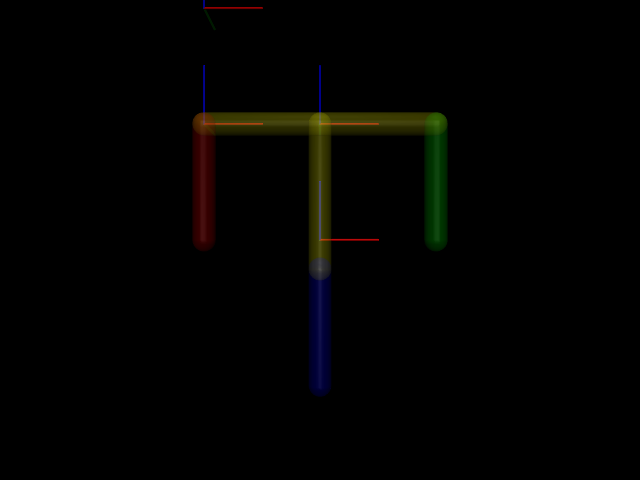

In [2]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>

    <body name="frame_world" pos="0 0 0">
      <geom type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
      <geom type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
      <geom type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
    </body>

    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 0.2"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 0.2"/>

      <body name="frame_0" pos="0 0 0">
        <geom type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <geom type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <geom type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>

      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 0.2"/>
        <body name="frame_1" pos="0 0 0">
          <geom type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
          <geom type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
          <geom type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
        </body>
        <body name="test" pos="0 0 0.2">
          <joint/>
          <body name="frame_test" pos="0 0 0">
            <geom type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
            <geom type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
            <geom type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
          </body>
        </body>
      </body>

      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 0.2"/>
      </body>

      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 0.2"/>
      </body>

    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
try:
  renderer
except:
  renderer = mujoco.Renderer(model, 480, 640)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera="fixed")
media.show_image(renderer.render())

## Timing
Let's see a video of it in action while we time the components:

In [3]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
try:
  renderer
except:
  renderer = mujoco.Renderer(model, 240, 320)

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10


# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
for i in range(n_frames): 
  while data.time * framerate < i:
    tic = time.time()
    mujoco.mj_step(model, data)
    sim_time += time.time() - tic
    n_steps += 1
  tic = time.time()
  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  render_time += time.time() - tic
  frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  2.05 μs/step  (487835Hz)
rendering:  4.32e+03 μs/frame (  231Hz)




Note that rendering is **much** slower than the simulated physics.

## Chaos
This is a [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) system (small pertubations in initial conditions accumulate quickly):

/tmp/ipykernel_27485/3068446776.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle[i] = data.joint('root').qpos


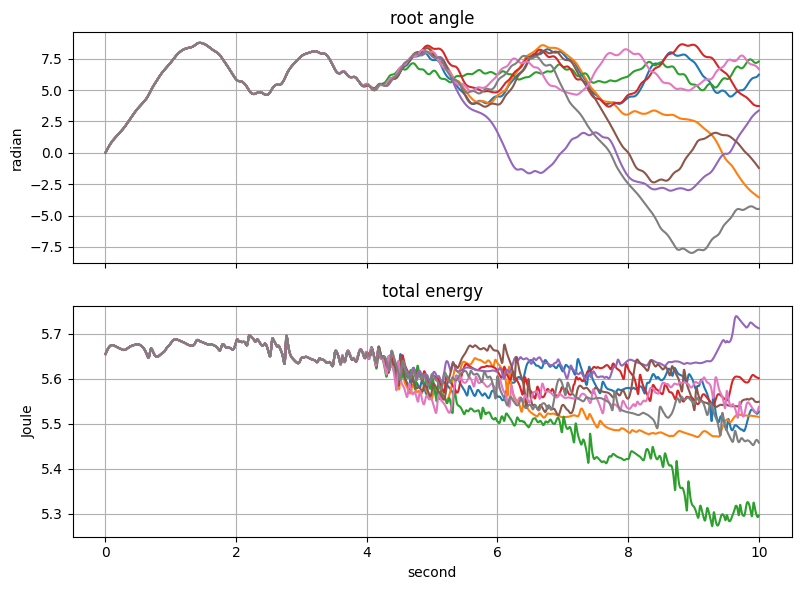

In [4]:
PERTURBATION = 1e-7
SIM_DURATION = 10 # seconds
NUM_REPEATS = 8

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
angle = np.zeros(n_steps)
energy = np.zeros(n_steps)

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):
  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 10 # root joint velocity
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)

  # simulate
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    angle[i] = data.joint('root').qpos
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax[0].plot(sim_time, angle)
  ax[1].plot(sim_time, energy)

# finalize plot
ax[0].set_title('root angle')
ax[0].set_ylabel('radian')
ax[1].set_title('total energy')
ax[1].set_ylabel('Joule')
ax[1].set_xlabel('second')
ax[0].grid(True)
ax[1].grid(True)
plt.tight_layout()

## Timestep and accuracy
**Question:** Why is the energy varying at all? There is no friction or damping, this system should conserve energy.

**Answer:** Because of the discretization of time.

If we decrease the timestep we'll get better accuracy and better energy conservation:

1000 steps at dt = 10ms
3162 steps at dt = 3.2ms
10000 steps at dt =  1ms
31622 steps at dt = 0.32ms
100000 steps at dt = 0.1ms


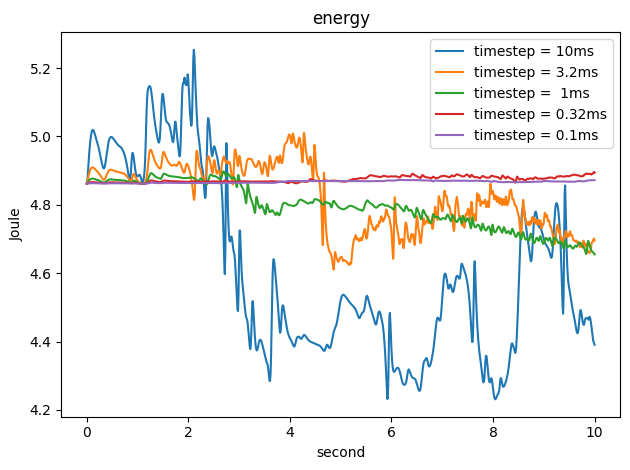

In [5]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))

# prepare plotting axes
_, ax = plt.subplots(1, 1)

for dt in TIMESTEPS:
   # set timestep, print
  model.opt.timestep = dt
  
  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps)

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 9 # root joint velocity

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    sim_time[i] = data.time
    energy[i] = data.energy[0] + data.energy[1]

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True)
plt.tight_layout()

## Timestep and divergence
When we increase the time step, the simulation quickly diverges:

simulating 1000 steps at dt = 10ms

stopped due to divergence (mjWARN_BADQACC) at timestep 437.

simulating 825 steps at dt = 12ms
stopped due to divergence (mjWARN_BADQACC) at timestep 218.


simulating 681 steps at dt = 15ms
stopped due to divergence (mjWARN_BADQACC) at timestep 167.


simulating 562 steps at dt = 18ms
stopped due to divergence (mjWARN_BADQACC) at timestep 111.


simulating 464 steps at dt = 22ms
stopped due to divergence (mjWARN_BADQACC) at timestep 83.


simulating 383 steps at dt = 26ms

stopped due to divergence (mjWARN_BADQACC) at timestep 54.

simulating 316 steps at dt = 32ms

stopped due to divergence (mjWARN_BADQACC) at timestep 38.



/tmp/ipykernel_27485/3689013484.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  warning = mujoco.mjtWarning(warning_index).name


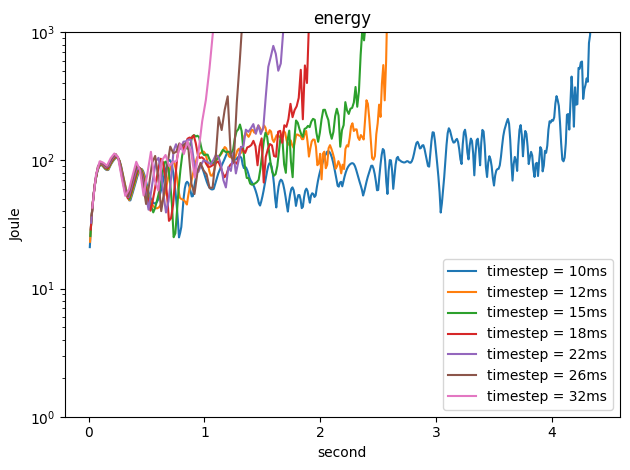

In [6]:
SIM_DURATION = 10 # (seconds)
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))

# get plotting axes
ax = plt.gca()

for dt in TIMESTEPS:
  # set timestep
  model.opt.timestep = dt

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)
  sim_time = np.zeros(n_steps)
  energy = np.zeros(n_steps) * np.nan
  speed = np.zeros(n_steps) * np.nan

  # initialize
  mujoco.mj_resetData(model, data)
  data.qvel[0] = 11 # set root joint velocity

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))
  for i in range(n_steps):
    mujoco.mj_step(model, data)
    if data.warning.number.any():
      warning_index = np.nonzero(data.warning.number)[0]
      warning = mujoco.mjtWarning(warning_index).name
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')
      break
    sim_time[i] = data.time
    energy[i] = sum(abs(data.qvel))
    speed[i] = np.linalg.norm(data.qvel)

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))
  ax.set_yscale('log')


# finalize plot
ax.set_ybound(1, 1e3)
ax.set_title('energy')
ax.set_ylabel('Joule')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()


# Contacts

Let's go back to our box and sphere example and give it a free joint:

""

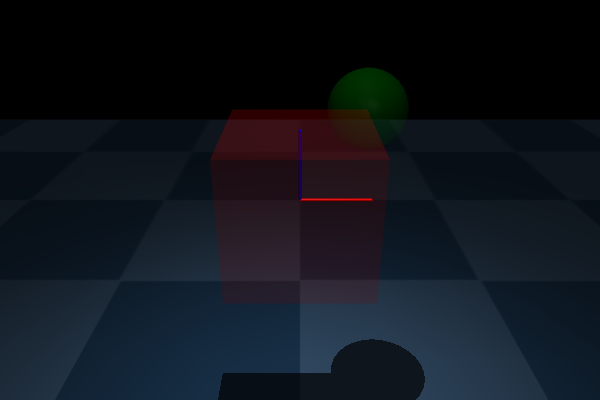

In [7]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3" 
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    
    <body name="frame_world" pos="0 0 0">
      <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
      <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
      <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
    </body>
    
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 0.1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 0.1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>

      <body name="frame_1" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>
      
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
try:
  renderer1
except:
  renderer1 = mujoco.Renderer(model, 400, 600)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer1.update_scene(data, "fixed")
media.show_image(renderer1.render())

Let render this body rolling on the floor, in slow-motion, while visualizing contact points and forces:

In [8]:
n_frames = 200
height = 240
width = 320
frames = []
try:
  renderer2
except:
  renderer2 = mujoco.Renderer(model, height, width)

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.01
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.03  # Этот параметр можно задать вместо высоты

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 5*np.random.randn(3)  # Вот таким образом можно задать скорость какому-то body объекту 

# simulate and render
for i in range(n_frames):
  data.qvel[3:6] = 5*np.random.randn(3)  # Вот таким образом можно задать скорость какому-то body объекту 
  while data.time < i/120.0: #1/4x real time
    mujoco.mj_step(model, data)
  renderer2.update_scene(data, "track", options)
  frame = renderer2.render()
  frames.append(frame)

# show video
media.show_video(frames, fps=30)

## Analysis of contact forces

Let's rerun the above simulation (with a different random initial condition) and
plot some values related to the contacts

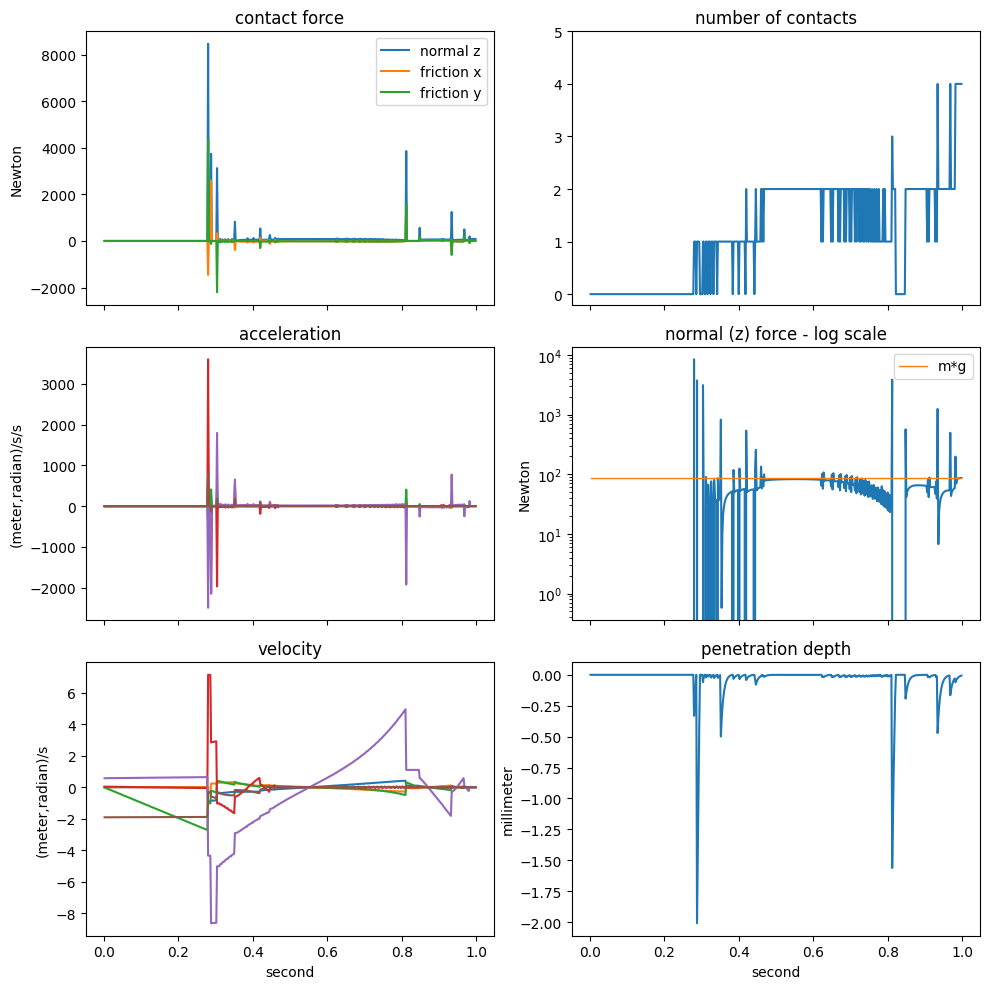

In [9]:
n_steps = 499

# allocate
sim_time = np.zeros(n_steps)
ncon = np.zeros(n_steps)
force = np.zeros((n_steps,3))
velocity = np.zeros((n_steps, model.nv))
penetration = np.zeros(n_steps)
acceleration = np.zeros((n_steps, model.nv))
forcetorque = np.zeros(6)

# random initial rotational velocity:
mujoco.mj_resetData(model, data)
data.qvel[3:6] = 2*np.random.randn(3)

# simulate and save data
for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  ncon[i] = data.ncon
  velocity[i] = data.qvel[:]
  acceleration[i] = data.qacc[:]
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):  # data.contact - структура данных которая хранит информацию о точках контакта в текущий момент времени
    mujoco.mj_contactForce(model, data, j, forcetorque)  # в forcetorque записывается результат
    force[i] += forcetorque[0:3]  # суммарная сила, которую испытывает система (сила реакции опоры, трение вдоль оси y, трение вдоль оси x)
    penetration[i] = min(penetration[i], c.dist)
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))

lines = ax[0,0].plot(sim_time, force)
ax[0,0].set_title('contact force')
ax[0,0].set_ylabel('Newton')
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'))

ax[1,0].plot(sim_time, acceleration)
ax[1,0].set_title('acceleration')
ax[1,0].set_ylabel('(meter,radian)/s/s')

ax[2,0].plot(sim_time, velocity)
ax[2,0].set_title('velocity')
ax[2,0].set_ylabel('(meter,radian)/s')
ax[2,0].set_xlabel('second')

ax[0,1].plot(sim_time, ncon)
ax[0,1].set_title('number of contacts')
ax[0,1].set_yticks(range(6))

ax[1,1].plot(sim_time, force[:,0])
ax[1,1].set_yscale('log')
ax[1,1].set_title('normal (z) force - log scale')
ax[1,1].set_ylabel('Newton')
z_gravity = -model.opt.gravity[2]
mg = model.body("box_and_sphere").mass[0] * z_gravity
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)
ax[1,1].legend()

ax[2,1].plot(sim_time, 1000*penetration)
ax[2,1].set_title('penetration depth')
ax[2,1].set_ylabel('millimeter')
ax[2,1].set_xlabel('second')

plt.tight_layout()

## Friction

Let's see the effect of changing friction values

In [10]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/> <!--zaxis-поворот плоскости пола, friction-изменение коэффициента трения-->
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>

    <body pos="0 0 .1">
      <joint/>
      <geom rgba="0 0 0 0.15"/>
      <body name="frame_1" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>
    </body>

    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".1" rgba="0 0 0 0.15"/>
      <body name="frame_2" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>
    </body>

  </worldbody>

</mujoco>
"""
n_frames = 60
height = 300
width = 300
frames = []

# load
model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
try:
  renderer3
except:
  renderer3 = mujoco.Renderer(model, height, width)

# simulate and render
mujoco.mj_resetData(model, data)
for i in range(n_frames):
  while data.time < i/30.0:
    mujoco.mj_step(model, data)
  renderer3.update_scene(data, "y")
  frame = renderer3.render()
  frames.append(frame)
media.show_video(frames, fps=30)

# Tendons, actuators and sensors

""

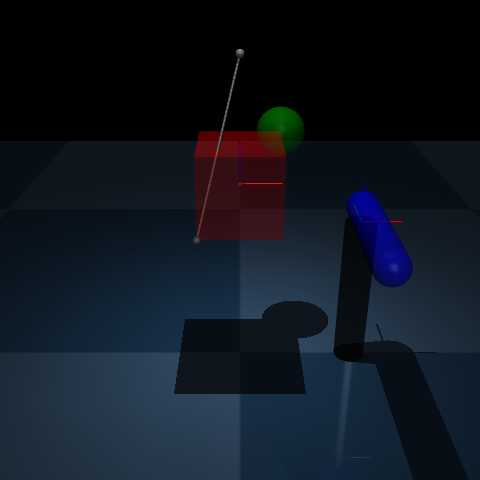

In [11]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04" rgba="0 0 0 0.5" />

    <body name="frame_world" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
    </body>

    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 0.5"/>

      <body name="frame_bat" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>

    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 .2"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 .2"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>

      <body name="frame_box" pos="0 0 0">
        <site type="capsule" fromto="0 0 0 0.1 0 0" size="0.002" rgba="1 0 0 1"/>  <!--Red-->
        <site type="capsule" fromto="0 0 0 0 0.1 0" size="0.002" rgba="0 1 0 1"/>  <!--Green-->
        <site type="capsule" fromto="0 0 0 0 0 0.1" size="0.002" rgba="0 0 1 1"/>  <!--Blue-->
      </body>

    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)
try:
  renderer4
except:
  renderer4 = mujoco.Renderer(model, 480, 480)
scene_option = mujoco.MjvOption()
scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer4.update_scene(data, "fixed")
media.show_image(renderer4.render())


actuated bat and passive "piñata":

In [1]:
scene_option = mujoco.MjvOption()
scene_option.frame = mujoco.mjtFrame.mjFRAME_BODY
scene_option.flags[mujoco.mjtLabel.mjLABEL_BODY] = True
scene_option.flags[mujoco.mjtLabel.mjLABEL_TENDON] = True

n_frames = 180
height = 240
width = 320
frames = []
fps = 60.0
times = []
sensordata = []

try:
  renderer4
except:
  renderer4 = mujoco.Renderer(model, height, width)

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

# simulate and render
for i in range(n_frames):
  while data.time < i/fps:
    mujoco.mj_step(model, data)
    times.append(data.time)
    sensordata.append(data.sensor('accelerometer').data.copy())
  renderer4.update_scene(data, "fixed", scene_option=scene_option)
  frame = renderer4.render()
  frames.append(frame)

media.show_video(frames, fps=fps)

NameError: name 'mujoco' is not defined

Let's plot the values measured by our accelerometer sensor:

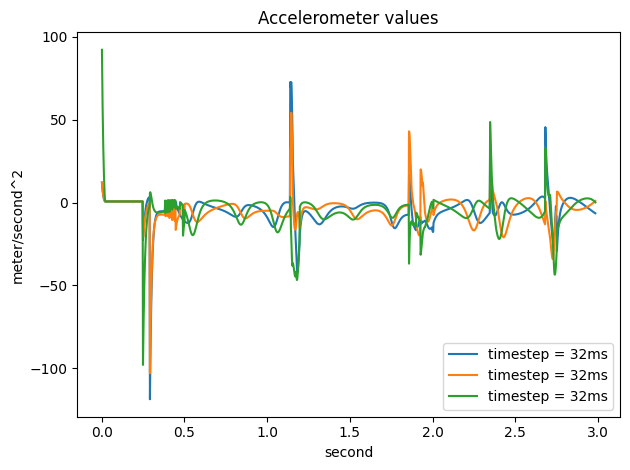

In [13]:
ax = plt.gca()

ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))

# finalize plot
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced rendering

Like joint visualization, additional rendering options are exposed as parameters to the `render` method.

Let's bring back our first model:

""

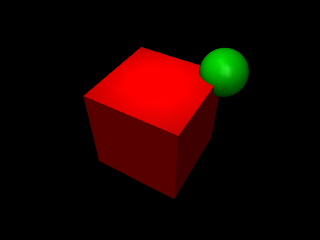

In [14]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
try:
  renderer5
except:
  renderer5 = mujoco.Renderer(model)

data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
renderer5.update_scene(data)
media.show_image(renderer5.render())

""

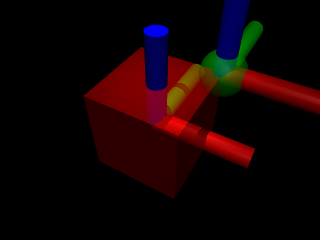

In [15]:
#@title Enable transparency and frame visualization

scene_option = mujoco.MjvOption()
scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM  # 
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
renderer5.update_scene(data, scene_option=scene_option)
frame = renderer5.render()
media.show_image(frame)

""

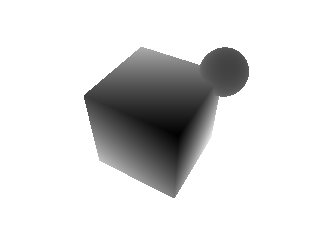

In [16]:
#@title Depth rendering

# update renderer to render depth
renderer5.enable_depth_rendering()

# reset the scene
renderer5.update_scene(data)

# depth is a float array, in meters.
depth = renderer5.render()

# Shift nearest values to the origin.
depth -= depth.min()
# # Scale by 3 mean distances of near rays.
depth /= 3*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)

media.show_image(pixels.astype(np.uint8))

renderer5.disable_depth_rendering()

""

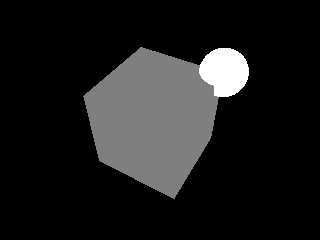

In [17]:
#@title Segmentation rendering

# update renderer to render segmentation
renderer5.enable_segmentation_rendering()

# reset the scene
renderer5.update_scene(data)

seg = renderer5.render()

# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()
pixels = 255*geom_ids
media.show_image(pixels.astype(np.uint8))

renderer5.disable_segmentation_rendering()

## The camera matrix

For a description of the camera matrix see the article [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) on Wikipedia.

In [18]:
def compute_camera_matrix(renderer, data):
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.vis.global_.fovy

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

Let's use the camera matrix to project from world to camera coordinates:

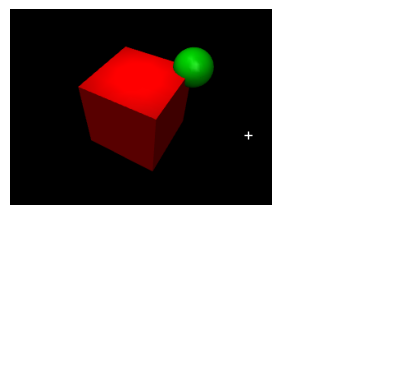

In [19]:
# reset the scene
renderer.update_scene(data)


# Get the world coordinates of the box corners
box_pos = data.geom_xpos[model.geom('red_box').id]
box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
box_size = model.geom_size[model.geom('red_box').id]
offsets = np.array([-1, 1]) * box_size[:, None]
xyz_local = np.stack(list(itertools.product(*offsets))).T
xyz_global = box_pos[:, None] + box_mat @ xyz_local

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Get the camera matrix.
m = compute_camera_matrix(renderer, data)

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = m @ corners_homogeneous
# x and y are in the pixel coordinate system.
x = xs / s
y = ys / s

# Render the camera view and overlay the projected corner coordinates.
pixels = renderer5.render()
fig, ax = plt.subplots(1, 1)
ax.imshow(pixels)
ax.plot(x, y, '+', c='w')
ax.set_axis_off()

## Modifying the scene

Let's add some arbitrary geometry to the `mjvScene`.

In [20]:
def get_geom_speed(model, data, geom_name):
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)
  geom_type = mujoco.mjtObj.mjOBJ_GEOM
  geom_id = data.geom(geom_name).id
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)
  return np.linalg.norm(geom_vel)

def add_visual_capsule(scene, point1, point2, radius, rgba):
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:
    return
  scene.ngeom += 1  # increment ngeom
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])

 # traces of time, position and speed
times = []
positions = []
speeds = []
offset = model.jnt_axis[0]/8  # offset along the joint axis

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))
      radius=.003*(1+speeds[i])
      point1 = positions[i] + offset*times[i]
      point2 = positions[i+1] + offset*times[i+1]
      add_visual_capsule(scn, point1, point2, radius, rgba)

duration = 6    # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

# Reset state and time.
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)

while data.time < duration:
  # append data to the traces
  positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())
  times.append(data.time)
  speeds.append(get_geom_speed(model, data, "green_sphere"))
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer5.update_scene(data)
    modify_scene(renderer5.scene)
    pixels = renderer5.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

В общем, с помощью последнего примера можно сделать трассировку.